# 📚 Automated Essay Scoring with BERT

This notebook trains a BERT-based model to automatically score student essays using the ASAP (Automated Student Assessment Prize) dataset.

## 🎯 Project Overview
- **Dataset**: ASAP Essay Scoring Dataset (12,976 essays)
- **Task**: Regression (predicting essay scores 0-1 scaled)
- **Model**: BERT-base-uncased fine-tuned for sequence classification
- **Evaluation**: QWK, Pearson Correlation, MAE, RMSE

### 📂 Data Loading and Initial Exploration

- This section loads the Automated Student Assessment Prize (ASAP) essay dataset from a TSV file. 
- It reads the data using pandas, retains only the essential columns for essay scoring 
- essay_id, essay_set, essay, domain1_score 

In [1]:
import pandas as pd

# Load dataset (use the TSV from Kaggle)
df = pd.read_csv("training_set_rel3.tsv", sep="\t", encoding="latin1")

# Keep relevant columns
df = df[['essay_id', 'essay_set', 'essay', 'domain1_score']]

# Display basic info
print(df.shape)
print(df.head())


(12976, 4)
   essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   domain1_score  
0              8  
1              9  
2              7  
3             10  
4              8  


### 🧹 Data Cleaning and Filtering

This section ensures the dataset contains only valid and readable essays before training.

- Removes **illegible or corrupted essays** containing terms like `"illegible"` or `"???"`.  
- Drops rows with **missing essay text or missing scores** to avoid null-related issues during training.  
- **Resets the DataFrame index** after cleaning for proper alignment.  
- Prints the **updated dataset shape** to confirm the final count of usable samples.


In [2]:
# Remove illegible or corrupted essays
df = df[~df['essay'].str.contains('illegible|\\?\\?\\?', case=False, na=False)]

# Drop any rows with missing text or scores
df = df.dropna(subset=['essay', 'domain1_score']).reset_index(drop=True)
print(f"After cleaning, dataset shape: {df.shape}")


After cleaning, dataset shape: (12703, 4)


### ⚖️ Score Normalization Across Essay Sets

This section standardizes essay scores within each essay set to ensure fair comparison during model training.

- Iterates through all **essay sets** to display their **minimum and maximum raw scores**.  
- Applies **min–max normalization** within each essay set to rescale scores between **0 and 1**.  
- Creates a new column called **`score_scaled`** representing the normalized scores.  
- Prints a preview of the scaled scores alongside original values for verification.

- **Formula**:

\[
\text{score\_scaled} = \frac{\text{domain1\_score} - \text{min\_score\_of\_set}}{\text{max\_score\_of\_set} - \text{min\_score\_of\_set}}
\]

Where:  
- `domain1_score` → the original essay score  
- `min_score_of_set` → minimum score in the essay’s set  
- `max_score_of_set` → maximum score in the essay’s set  

- **Implementation in Code**: Applies the formula row-wise using `df.apply` in pandas.

In [3]:
# Check score ranges per essay set
for s in sorted(df['essay_set'].unique()):
    min_score = df[df['essay_set'] == s]['domain1_score'].min()
    max_score = df[df['essay_set'] == s]['domain1_score'].max()
    print(f"Set {s}: min={min_score}, max={max_score}")

print("=" *50)    

# Scale scores to 0-1 range per essay set
df['score_scaled'] = df.apply(
    lambda x: (x['domain1_score'] - df[df['essay_set'] == x['essay_set']]['domain1_score'].min()) /
              (df[df['essay_set'] == x['essay_set']]['domain1_score'].max() -
               df[df['essay_set'] == x['essay_set']]['domain1_score'].min()),
    axis=1
)
print(df[['essay_set', 'domain1_score', 'score_scaled']].head())

Set 1: min=2, max=12
Set 2: min=1, max=6
Set 3: min=0, max=3
Set 4: min=0, max=3
Set 5: min=0, max=4
Set 6: min=0, max=4
Set 7: min=2, max=24
Set 8: min=10, max=60
   essay_set  domain1_score  score_scaled
0          1              8           0.6
1          1              9           0.7
2          1              7           0.5
3          1             10           0.8
4          1              8           0.6


### ✨ Text Preprocessing and Cleaning

This section defines and applies a function to clean essay text for model training.

- **Define `clean_text` function** to standardize essay content.  
- **Remove HTML tags** (`<...>`) using regular expressions.  
- **Remove special characters** leaving only letters, numbers, and spaces.  
- **Condense multiple spaces** into one and remove leading/trailing spaces.  
- **Apply the cleaning function** to the `essay` column of the DataFrame.

In [4]:
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # remove HTML
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # remove special chars
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

df['essay'] = df['essay'].apply(clean_text)


### 🧪 Train–Validation Split

This section splits the dataset into **training and validation sets** for model evaluation.

- **Import `train_test_split`** from `scikit-learn` to split data randomly.  
- **Split essays and their scaled scores** into training (90%) and validation (10%) sets.  
- **Set a random seed (`random_state=42`)** for reproducible splits.  
- **Print sizes** of training and validation sets to verify the split.

In [5]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_scores, val_scores = train_test_split(
    df['essay'], df['score_scaled'], test_size=0.1, random_state=42
)
print(f"Training set size: {len(train_texts)}, Validation set size: {len(val_texts)}")

Training set size: 11432, Validation set size: 1271


### 🔤 Tokenization with BERT

This section converts essay text into **token IDs** suitable for BERT input.

- **Import `AutoTokenizer`** from Hugging Face Transformers.  
- **Load the BERT tokenizer** (`bert-base-uncased`) to match the pretrained model.  
- **Tokenize training essays** with:  
  - `truncation=True` → cut essays longer than 512 tokens  
  - `padding=True` → pad shorter essays to the same length  
  - `return_tensors='pt'` → return PyTorch tensors  
- **Repeat tokenization for validation essays** to prepare inputs for evaluation.

In [ ]:
#DO NOT RUN. MODEL IS ALREADY TRAINED

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(
    list(train_texts), truncation=True, padding=True, max_length=512, return_tensors='pt'
)
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=512, return_tensors='pt'
)


### 📦 Creating a Custom PyTorch Dataset

This section defines a **custom dataset class** to feed tokenized essays and scores into a BERT model.

- **Import `torch`** to use PyTorch utilities.  
- **Define `EssayDataset` class** inheriting from `torch.utils.data.Dataset`:  
  - `__init__` stores **tokenized encodings** and **labels**.  
  - `__getitem__` returns a single data point as a dictionary with:  
    - token IDs, attention masks, and other encodings  
    - the corresponding **label** converted to a float tensor  
  - `__len__` returns the total number of samples.  
- **Create training and validation datasets** (`train_dataset`, `val_dataset`) from tokenized inputs and scaled scores, ready for PyTorch DataLoader.


In [ ]:
#DO NOT RUN. MODEL IS ALREADY TRAINED

import torch

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EssayDataset(train_encodings, train_scores)
val_dataset = EssayDataset(val_encodings, val_scores)


### 🏷️ Model Training with Hugging Face Trainer

This cell sets up and runs the training process for the BERT-based essay scoring model using Hugging Face's `Trainer` API.  
Key steps:

- **Model Loading:** Loads a BERT model for regression (`num_labels=1`).
- **Training Arguments:** Configures training parameters such as:
  - Output directory for results and logs
  - Number of epochs
  - Batch sizes for training and evaluation
  - Warmup steps and weight decay for optimization
  - Evaluation and saving strategies (per epoch)
  - Learning rate
  - Apple Silicon GPU support (`use_mps_device=True`)
- **Trainer Initialization:** Combines the model, training arguments, training dataset, and validation dataset.
- **Model Training:** Runs the training loop with `trainer.train()`.

This cell fine-tunes the BERT model on your essay data for automated scoring.

In [ ]:
#DO NOT RUN. MODEL IS ALREADY TRAINED

from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

# Load model for REGRESSION (num_labels=1 for regression tasks)
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=1  # For regression (predicting continuous scores)
)

# Use 'eval_strategy' instead of 'evaluation_strategy'
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=50,
    weight_decay=0.01,
    eval_strategy='epoch',
    logging_dir='./logs',
    learning_rate=2e-5,
    save_strategy='epoch',
    load_best_model_at_end=True,
    use_mps_device=True,  # Enable Apple Silicon GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

### 📦 Model Loading and Evaluation Setup

This cell loads the previously trained BERT model and tokenizer from the saved directory (`./essay_scoring_model`).  
It then prepares the validation data for evaluation:

- **Model & Tokenizer Loading:** Loads the fine-tuned BERT model and its tokenizer.
- **Validation Encoding:** Tokenizes the validation essays (`val_texts`) to create PyTorch tensors for input.
- **Custom Dataset:** Defines the `EssayDataset` class to wrap tokenized inputs and labels for PyTorch.
- **Validation Dataset:** Instantiates the validation dataset using tokenized essays and their scores.
- **Trainer Setup:** Re-instantiates the Hugging Face `Trainer` with the loaded model and validation dataset for evaluation or inference.

This cell is used for running predictions and evaluating model performance, not for training.

In [8]:
from transformers import Trainer, AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./essay_scoring_model')
tokenizer = AutoTokenizer.from_pretrained('./essay_scoring_model')

# Re-create validation encodings and dataset
val_encodings = tokenizer(
    list(val_texts), truncation=True, padding=True, max_length=512, return_tensors='pt'
)

class EssayDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        return item
    def __len__(self):
        return len(self.labels)

val_dataset = EssayDataset(val_encodings, val_scores)

# Re-instantiate Trainer with loaded model
trainer = Trainer(
    model=model,
    eval_dataset=val_dataset
)

### 📊 Model Evaluation and Metrics Calculation

This cell runs the evaluation of the loaded BERT model on the validation dataset and calculates key performance metrics:

- **Predictions:** Uses the Hugging Face `Trainer` to predict scores for the validation essays.
- **Rescaling:** Converts predicted and actual scores from the normalized (0–1) scale back to their original ranges for each essay set.
- **Metrics Computation:** Calculates several metrics to assess model performance:
  - Quadratic Weighted Kappa (QWK)
  - Pearson Correlation
  - R² Score
  - Mean Absolute Error (MAE)
  - Root Mean Squared Error (RMSE)
- **Printing Results:** Displays the computed metrics for easy review.

This cell helps you understand how well your BERT model predicts essay scores compared to the ground truth.

In [9]:
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(val_dataset)
preds = predictions.predictions.squeeze()
labels = predictions.label_ids

# For QWK, we need to convert scaled scores back to original scale
# Let's get the essay_set for each validation sample
val_essay_sets = df.loc[val_texts.index, 'essay_set'].values

def rescale_predictions(scaled_preds, scaled_labels, essay_sets):
    """Convert 0-1 scaled scores back to original scale"""
    score_ranges = {
        1: (2, 12), 2: (1, 6), 3: (0, 3), 4: (0, 3),
        5: (0, 4), 6: (0, 4), 7: (2, 24), 8: (10, 60)
    }
    
    original_preds = []
    original_labels = []
    
    for pred, label, essay_set in zip(scaled_preds, scaled_labels, essay_sets):
        min_score, max_score = score_ranges[essay_set]
        original_pred = pred * (max_score - min_score) + min_score
        original_label = label * (max_score - min_score) + min_score
        original_preds.append(round(original_pred))
        original_labels.append(round(original_label))
    
    return np.array(original_preds), np.array(original_labels)

# Rescale predictions
original_preds, original_labels = rescale_predictions(preds, labels, val_essay_sets)

# Calculate metrics
mae_b = mean_absolute_error(labels, preds)
rmse_b = np.sqrt(mean_squared_error(labels, preds))
r2_b = r2_score(labels, preds)
pearson_corr_b, _ = pearsonr(preds, labels)

# QWK (on original scale)
qwk_b = cohen_kappa_score(original_labels, original_preds, weights='quadratic')

print("=" * 50)
print("📊 MODEL PERFORMANCE METRICS")
print("=" * 50)
print(f"Quadratic Weighted Kappa (QWK): {qwk_b:.4f}")
print(f"Pearson Correlation:            {pearson_corr_b:.4f}")
print(f"R² Score:                       {r2_b:.4f}")
print(f"Mean Absolute Error (MAE):      {mae_b:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_b:.4f}")
print("=" * 50)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


📊 MODEL PERFORMANCE METRICS
Quadratic Weighted Kappa (QWK): 0.9867
Pearson Correlation:            0.8345
R² Score:                       0.6766
Mean Absolute Error (MAE):      0.1013
Root Mean Squared Error (RMSE): 0.1356


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# TF-IDF features (unigrams + bigrams)
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 3),
    
)
X_tfidf = vectorizer.fit_transform(df['essay'])

# Simple numeric features
df['essay_len'] = df['essay'].apply(len)
df['word_count'] = df['essay'].apply(lambda x: len(x.split()))
df['avg_word_len'] = df['essay'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)

numeric_features = df[['essay_len', 'word_count', 'avg_word_len']].values

# Combine TF-IDF + numeric
from scipy.sparse import csr_matrix
X = hstack([X_tfidf, csr_matrix(numeric_features)])
y = df['score_scaled'].values

print(f"Final feature matrix shape: {X.shape}")



Final feature matrix shape: (12703, 10003)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (10162, 10003), Validation shape: (2541, 10003)


In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, cohen_kappa_score
from scipy.stats import pearsonr
import numpy as np

# Train Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

# Predict on validation set
y_pred = ridge.predict(X_val)

# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
pearson_corr, _ = pearsonr(y_pred, y_val)

# Rescale predictions and labels for QWK
score_ranges = {
    1: (2, 12), 2: (1, 6), 3: (0, 3), 4: (0, 3),
    5: (0, 4), 6: (0, 4), 7: (2, 24), 8: (10, 60)
}

def rescale(scaled, essay_sets):
    original = []
    for val, s in zip(scaled, essay_sets):
        min_score, max_score = score_ranges[s]
        orig = val * (max_score - min_score) + min_score
        original.append(round(orig))
    return np.array(original)

# Get essay_set for each validation sample
val_essay_sets = df.iloc[X_val.indices]['essay_set'].values if hasattr(X_val, 'indices') else df.iloc[X_val.nonzero()[0]]['essay_set'].values

y_pred_orig = rescale(y_pred, val_essay_sets)
y_val_orig = rescale(y_val, val_essay_sets)

# Calculate QWK
qwk = cohen_kappa_score(y_val_orig, y_pred_orig, weights='quadratic')

metrics_df = pd.DataFrame({
    'Metric': [
        'Quadratic Weighted Kappa (QWK)',
        'Pearson Correlation',
        'R² Score',
        'Mean Absolute Error (MAE)',
        'Root Mean Squared Error (RMSE)'
    ],
    'Ridge': [
        qwk,
        pearson_corr,
        r2,
        mae,
        rmse
    ],
    'BERT': [
        qwk_b,
        pearson_corr_b,
        r2_b,
        mae_b,
        rmse_b
    ]
})

metrics_df.to_csv('model_eval_metrics.csv', index=False)
print("✅ Saved evaluation metrics to 'model_eval_metrics.csv'")

print("=" * 54)
print("📊 MODEL PERFORMANCE METRICS         RIDGE\t BERT"    )
print("=" * 54)
print(f"Quadratic Weighted Kappa (QWK):     {qwk:.4f}\t{qwk_b:.4f}")
print(f"Pearson Correlation:                {pearson_corr:.4f}\t{pearson_corr_b:.4f}")
print(f"R² Score:                           {r2:.4f}\t{r2_b:.4f}")
print(f"Mean Absolute Error (MAE):          {mae:.4f}\t{mae_b:.4f}")
print(f"Root Mean Squared Error (RMSE):     {rmse:.4f}\t{rmse_b:.4f}")
print("=" * 54)

✅ Saved evaluation metrics to 'model_eval_metrics.csv'
📊 MODEL PERFORMANCE METRICS         RIDGE	 BERT
Quadratic Weighted Kappa (QWK):     0.9240	0.9867
Pearson Correlation:                0.7327	0.8345
R² Score:                           0.5369	0.6766
Mean Absolute Error (MAE):          0.1262	0.1013
Root Mean Squared Error (RMSE):     0.1629	0.1356


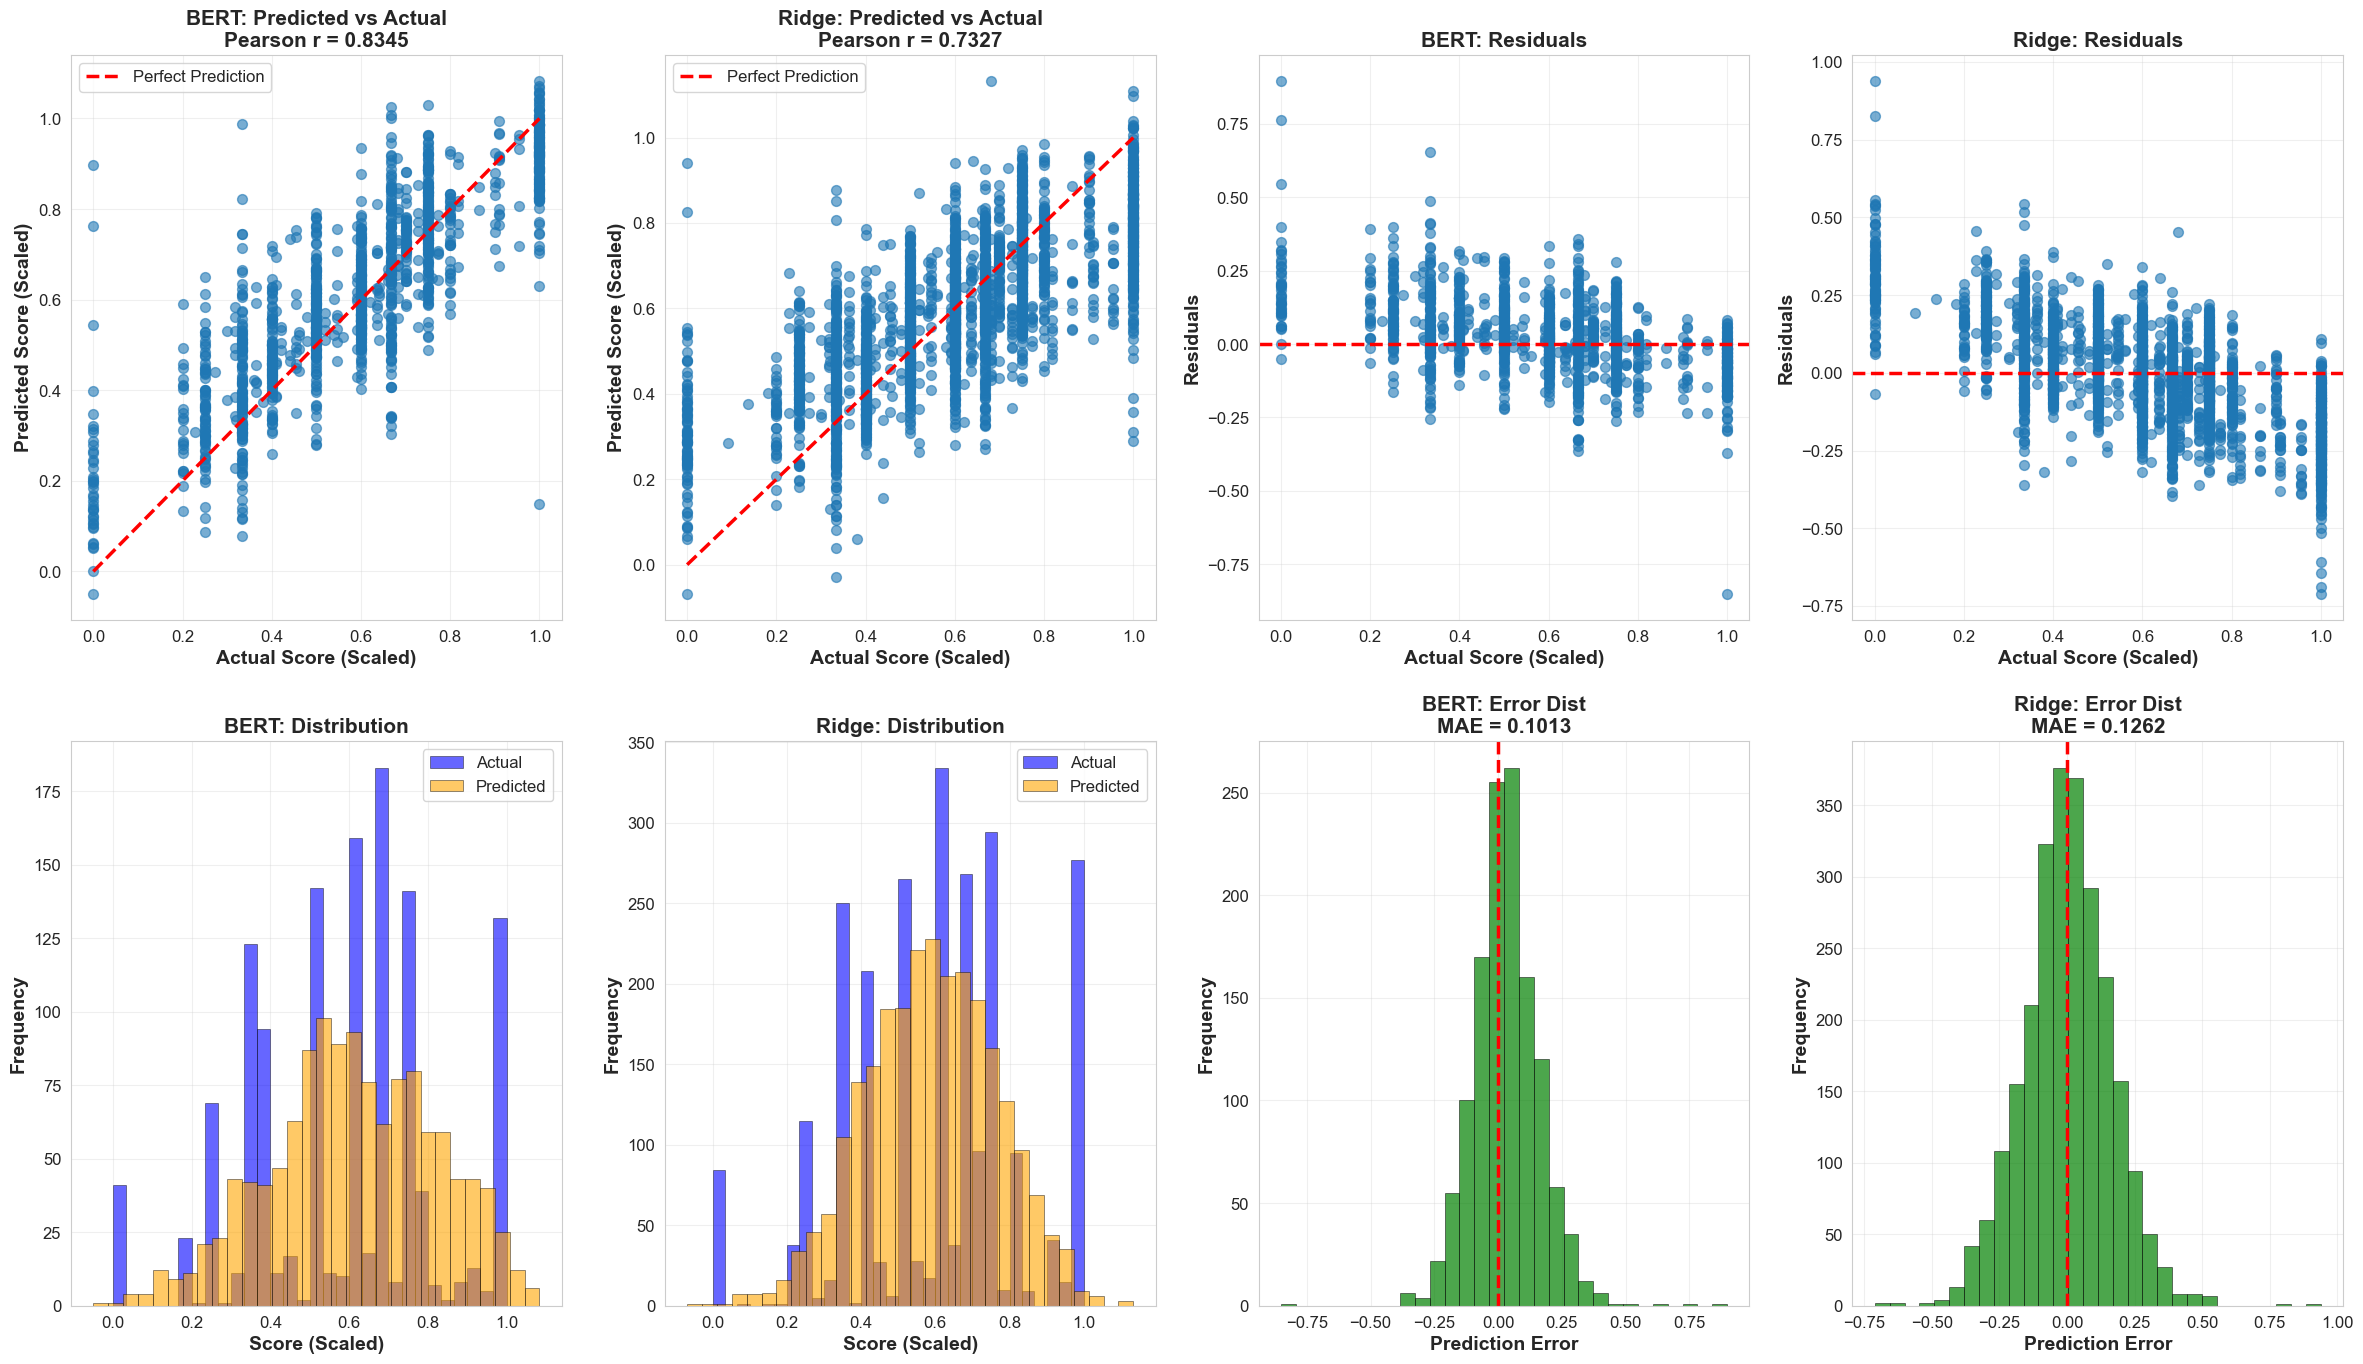

✅ Saved side-by-side BERT and Ridge comparison as 'all_comparison.png'


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Increased figure size for better readability
fig, axes = plt.subplots(2, 4, figsize=(24, 14))

# Increase marker size and adjust alpha for better visibility
marker_size = 50
alpha_val = 0.6

# 1a. Scatter Plot: Predicted vs Actual (Scaled) - BERT
axes[0, 0].scatter(labels, preds, alpha=alpha_val, s=marker_size)
axes[0, 0].plot([0, 1], [0, 1], 'r--', lw=2.5, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Predicted Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 0].set_title(f'BERT: Predicted vs Actual\nPearson r = {pearson_corr_b:.4f}', fontsize=15, fontweight='bold')
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(labelsize=12)

# 1b. Scatter Plot: Predicted vs Actual (Scaled) - Ridge
axes[0, 1].scatter(y_val, y_pred, alpha=alpha_val, s=marker_size)
axes[0, 1].plot([0, 1], [0, 1], 'r--', lw=2.5, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Predicted Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 1].set_title(f'Ridge: Predicted vs Actual\nPearson r = {pearson_corr:.4f}', fontsize=15, fontweight='bold')
axes[0, 1].legend(fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(labelsize=12)

# 2a. Residual Plot - BERT
residuals_bert = preds - labels
axes[0, 2].scatter(labels, residuals_bert, alpha=alpha_val, s=marker_size)
axes[0, 2].axhline(y=0, color='r', linestyle='--', lw=2.5)
axes[0, 2].set_xlabel('Actual Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('Residuals', fontsize=14, fontweight='bold')
axes[0, 2].set_title('BERT: Residuals', fontsize=15, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].tick_params(labelsize=12)

# 2b. Residual Plot - Ridge
residuals_ridge = y_pred - y_val
axes[0, 3].scatter(y_val, residuals_ridge, alpha=alpha_val, s=marker_size)
axes[0, 3].axhline(y=0, color='r', linestyle='--', lw=2.5)
axes[0, 3].set_xlabel('Actual Score (Scaled)', fontsize=14, fontweight='bold')
axes[0, 3].set_ylabel('Residuals', fontsize=14, fontweight='bold')
axes[0, 3].set_title('Ridge: Residuals', fontsize=15, fontweight='bold')
axes[0, 3].grid(True, alpha=0.3)
axes[0, 3].tick_params(labelsize=12)

# 3a. Distribution of Predictions vs Actual - BERT
axes[1, 0].hist(labels, bins=30, alpha=0.6, label='Actual', color='blue', edgecolor='black', linewidth=0.5)
axes[1, 0].hist(preds, bins=30, alpha=0.6, label='Predicted', color='orange', edgecolor='black', linewidth=0.5)
axes[1, 0].set_xlabel('Score (Scaled)', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 0].set_title('BERT: Distribution', fontsize=15, fontweight='bold')
axes[1, 0].legend(fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(labelsize=12)

# 3b. Distribution of Predictions vs Actual - Ridge
axes[1, 1].hist(y_val, bins=30, alpha=0.6, label='Actual', color='blue', edgecolor='black', linewidth=0.5)
axes[1, 1].hist(y_pred, bins=30, alpha=0.6, label='Predicted', color='orange', edgecolor='black', linewidth=0.5)
axes[1, 1].set_xlabel('Score (Scaled)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 1].set_title('Ridge: Distribution', fontsize=15, fontweight='bold')
axes[1, 1].legend(fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(labelsize=12)

# 4a. Error Distribution - BERT
axes[1, 2].hist(residuals_bert, bins=30, color='green', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1, 2].axvline(x=0, color='r', linestyle='--', lw=2.5)
axes[1, 2].set_xlabel('Prediction Error', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 2].set_title(f'BERT: Error Dist\nMAE = {mae_b:.4f}', fontsize=15, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].tick_params(labelsize=12)

# 4b. Error Distribution - Ridge
axes[1, 3].hist(residuals_ridge, bins=30, color='green', alpha=0.7, edgecolor='black', linewidth=0.5)
axes[1, 3].axvline(x=0, color='r', linestyle='--', lw=2.5)
axes[1, 3].set_xlabel('Prediction Error', fontsize=14, fontweight='bold')
axes[1, 3].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 3].set_title(f'Ridge: Error Dist\nMAE = {mae:.4f}', fontsize=15, fontweight='bold')
axes[1, 3].grid(True, alpha=0.3)
axes[1, 3].tick_params(labelsize=12)

plt.tight_layout(pad=2.0)
plt.savefig('all_comparison.png', dpi=400, bbox_inches='tight')
plt.show()

print("✅ Saved side-by-side BERT and Ridge comparison as 'all_comparison.png'")

In [14]:
def predict_essay_score_bert(essay_text, model, tokenizer, essay_set, score_ranges):
    import torch

    essay_text = clean_text(essay_text)
    inputs = tokenizer(
        essay_text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Ensure model is on MPS if available
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        score_scaled = outputs.logits.squeeze().item()

    min_score, max_score = score_ranges[essay_set]
    score_orig = score_scaled * (max_score - min_score) + min_score

    return round(score_orig, 2)

def predict_essay_score_ridge(essay_text, essay_set, vectorizer, ridge_model, score_ranges):
    # Clean and vectorize essay
    essay_clean = clean_text(essay_text)
    X_tfidf = vectorizer.transform([essay_clean])
    # Add numeric features
    essay_len = len(essay_clean)
    word_count = len(essay_clean.split())
    avg_word_len = np.mean([len(w) for w in essay_clean.split()]) if word_count > 0 else 0
    numeric = np.array([[essay_len, word_count, avg_word_len]])
    from scipy.sparse import hstack, csr_matrix
    X = hstack([X_tfidf, csr_matrix(numeric)])
    # Predict
    score_scaled = ridge_model.predict(X)[0]
    min_score, max_score = score_ranges[essay_set]
    score_orig = score_scaled * (max_score - min_score) + min_score
    return round(score_orig, 2)

In [15]:
# Example usage
score_ranges = {
    1: (0, 10), 2: (1, 6), 3: (0, 3), 4: (0, 3),
    5: (0, 4), 6: (0, 4), 7: (2, 24), 8: (10, 60)
}
essay = """Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
Ai is very good for teaching.
"""

essay_set =1  # Change as needed

# Choose model: "bert" or "ridge"
model_type = "ridge"  # or "ridge"

if model_type == "bert":
    predicted_score = predict_essay_score_bert(
        essay, model, tokenizer, essay_set, score_ranges
    )
elif model_type == "ridge":
    predicted_score = predict_essay_score_ridge(
        essay, essay_set, vectorizer, ridge, score_ranges
    )

else:
    raise ValueError("model_type must be 'bert' or 'ridge'")

print("Predicted score:", predicted_score)


Predicted score: 1.95
